# PyTorch GAN

We can use PyTorch to implement generative adversarial networks.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.nn.functional as F
import torchvision.models as models

from PIL import Image, ImageFilter, ImageChops
import matplotlib.pyplot as plt

import requests
import copy
from io import BytesIO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

In [2]:
batch_size = 32
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                               
train_set = datasets.MNIST(root=".", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

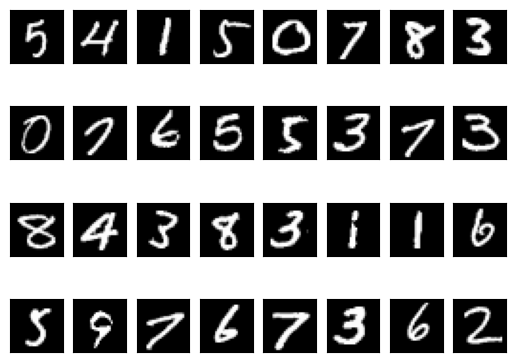

In [3]:
samples, labels = next(iter(train_loader))

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## Define discriminator and generator models

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # We don't use Conv layers here but we vectorize our inputs
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
            #nn.Sigmoid(), #not using sigmoid activation togheter with BCEWithLogitsLoss instead of BCELoss seems to prevent Discriminator loss going to zero for longer
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # We use the Tanh() activation fucntion so that our outputs lie between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



discriminator = Discriminator().to(device=device)
generator = Generator().to(device=device)

## Training

In [6]:
def train_gan(discriminator, generator, train_loader, epochs, gen_optimizer, disc_optimizer, loss_function, batch_size):
    for epoch in range(epochs):
        for n, (samples, labels) in enumerate(train_loader):
            # Get data for training the discriminator
            real_samples = samples.to(device=device)
            real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
            generated_samples = generator(latent_space_samples)
            generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
            all_samples = torch.cat((real_samples, generated_samples))
            all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

            # Training the discriminator
            discriminator.zero_grad()
            output_discriminator = discriminator(all_samples)
            loss_discriminator = loss_function(output_discriminator, all_samples_labels)
            loss_discriminator.backward()
            disc_optimizer.step()

            # Data for training the generator
            latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

            # Training the generator
            generator.zero_grad()
            generated_samples = generator(latent_space_samples)
            output_discriminator_generated = discriminator(generated_samples)
            loss_generator = loss_function(output_discriminator_generated, real_samples_labels)
            loss_generator.backward()
            gen_optimizer.step()

            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch}, Generator Loss: {loss_generator}, Discriminator Loss: {loss_discriminator}")

In [8]:
lr = 0.0001
epochs = 50
loss_function = nn.BCEWithLogitsLoss() #nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr*0.1)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

train_gan(discriminator, generator, train_loader, epochs, optimizer_generator, optimizer_discriminator, loss_function, batch_size)

Epoch: 0, Generator Loss: 0.37764984369277954, Discriminator Loss: 0.642520546913147
Epoch: 1, Generator Loss: 5.805818557739258, Discriminator Loss: 0.08033321797847748
Epoch: 2, Generator Loss: 10.742496490478516, Discriminator Loss: 0.01943090185523033
Epoch: 3, Generator Loss: 9.924495697021484, Discriminator Loss: 0.002415686147287488
Epoch: 4, Generator Loss: 10.911266326904297, Discriminator Loss: 0.0032861330546438694
Epoch: 5, Generator Loss: 8.847827911376953, Discriminator Loss: 0.06059781089425087
Epoch: 6, Generator Loss: 5.527049541473389, Discriminator Loss: 0.1090506911277771
Epoch: 7, Generator Loss: 5.2401838302612305, Discriminator Loss: 0.010629141703248024
Epoch: 8, Generator Loss: 4.453344345092773, Discriminator Loss: 0.23784670233726501
Epoch: 9, Generator Loss: 4.073084354400635, Discriminator Loss: 0.13040514290332794
Epoch: 10, Generator Loss: 3.742614269256592, Discriminator Loss: 0.12786275148391724
Epoch: 11, Generator Loss: 2.514376640319824, Discriminato

## Generate samples

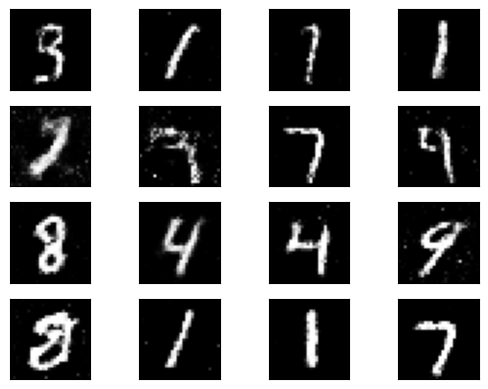

In [9]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

## Improvements DCGAN
We can improve our models by using Conv layers

In [ ]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, channels=1, num_of_feature_maps=64):
        super().__init__()
        self.model = nn.Sequential(

            nn.Conv2d(channels, num_of_feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps, num_of_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps * 2, num_of_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps * 4, num_of_feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_of_feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class GeneratorCNN(nn.Module):
    def __init__(self, latent_vector_size=100, num_of_feature_maps=64, channels=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d( latent_vector_size, num_of_feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(num_of_feature_maps * 8, num_of_feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d( num_of_feature_maps * 4, num_of_feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d( num_of_feature_maps * 2, num_of_feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(num_of_feature_maps),
            nn.ReLU(True),

            nn.ConvTranspose2d( num_of_feature_maps, channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output



discriminator = DiscriminatorCNN().to(device=device)
generator = GeneratorCNN().to(device=device)

In [ ]:
train_gan(discriminator, generator, train_loader, epochs, gen_optimizer, disc_optimizer, loss_function, batch_size)